In [1]:
import imageio
import glob
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from matplotlib import pyplot

2021-07-09 16:42:22.390718: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.astype('float32')
x_train = (x_train / 127.5) - 1 
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).\
shuffle(60000).batch(128)

2021-07-09 16:42:29.766723: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-09 16:42:29.767309: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-07-09 16:42:29.797386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-09 16:42:29.797637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 computeCapability: 6.1
coreClock: 1.6705GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2021-07-09 16:42:29.797656: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-09 16:42:29.799640: I tensorflow/stream_executor/platform/default/

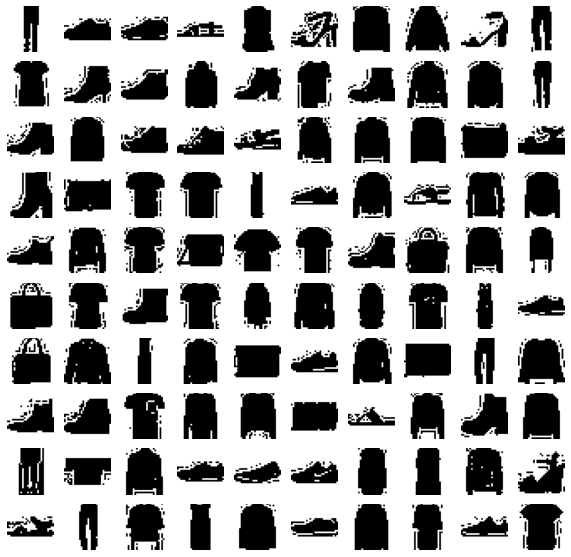

In [3]:
plt.figure(figsize=(10, 10))
for images,_ in train_dataset.take(1):
    for i in range(100):
        ax = plt.subplot(10, 10, i + 1)
        plt.imshow(images[i,:,:,0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

In [4]:
BATCH_SIZE=128
latent_dim = 100

In [5]:
# label input
con_label = layers.Input(shape=(1,))

# image generator input
latent_vector = layers.Input(shape=(100,))

In [6]:
def label_conditioned_gen(n_classes=10, embedding_dim=100):
    # embedding for categorical input
    label_embedding = layers.Embedding(n_classes, embedding_dim)(con_label)
    # linear multiplication
    n_nodes = 7 * 7
    label_dense = layers.Dense(n_nodes)(label_embedding)
    # reshape to additional channel
    label_reshape_layer = layers.Reshape((7, 7, 1))(label_dense)
    return label_reshape_layer

def latent_gen(latent_dim=100):
    # image generator input
    in_lat = layers.Input(shape=(latent_dim,))
    n_nodes = 128 * 7 * 7
    latent_dense = layers.Dense(n_nodes)(latent_vector)
    latent_dense = layers.LeakyReLU(alpha=0.2)(latent_dense)
    latent_reshape = layers.Reshape((7, 7, 128))(latent_dense)
    return latent_reshape

In [7]:
def con_generator():
    latent_vector_output = label_conditioned_gen()
    label_output = latent_gen()
    # merge image gen and label input
    merge = layers.Concatenate()([latent_vector_output, label_output])
    # upsample to 14x14
    x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    x = layers.LeakyReLU(alpha=0.2)(x)
    # upsample to 28x28
    x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    # output
    out_layer = layers.Conv2D(1, (7,7), activation='tanh', padding='same')(x)
    # define model
    model = tf.keras.Model([latent_vector, con_label], out_layer)
    return model

In [8]:
conditional_gen = con_generator()

In [9]:
# conditional_gen.save('con-gen.h5')

In [10]:
conditional_gen.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 6272)         633472      input_2[0][0]                    
______________________________________________________________________________________________

In [11]:
def label_condition_disc(in_shape=(28, 28, 1), n_classes=10, embedding_dim=100):
    # label input
    con_label = layers.Input(shape=(1,))
    # embedding for categorical input
    label_embedding = layers.Embedding(n_classes, embedding_dim)(con_label)
    # scale up to image dimensions with linear activation
    nodes = in_shape[0] * in_shape[1] * in_shape[2]
    label_dense = layers.Dense(nodes)(label_embedding)
    # reshape to additional channel
    label_reshape_layer = layers.Reshape((in_shape[0], in_shape[1], 1))(label_dense)
    # image input
    return con_label, label_reshape_layer


def image_disc(in_shape=(28,28, 1)):
    inp_image = layers.Input(shape=in_shape)
    return inp_image 

In [12]:
def con_discriminator():
    con_label, label_condition_output = label_condition_disc()
    inp_image_output = image_disc()
    # concat label as a channel
    merge = layers.Concatenate()([inp_image_output, label_condition_output])
    # downsample
    x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    x = layers.LeakyReLU(alpha=0.2)(x)
    # downsample
    x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    # flatten feature maps
    flattened_out = layers.Flatten()(x)
    # dropout
    dropout = layers.Dropout(0.4)(flattened_out)
    # output
    dense_out = layers.Dense(1, activation='sigmoid')(dropout)
    # define model
    model = tf.keras.Model([inp_image_output, con_label], dense_out)
    return model

In [13]:
conditional_discriminator = con_discriminator()

In [14]:
conditional_discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1000        input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 784)       79184       embedding_1[0][0]                
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
____________________________________________________________________________________________

In [15]:
# conditional_discriminator.save('con-disc.h5')

In [16]:
# ?layers.Embedding

In [17]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [18]:
def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    #print(gen_loss)
    return gen_loss

In [19]:
def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    #print(total_loss)
    return disc_loss

In [20]:
learning_rate = 0.0002 
generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )
discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

In [21]:
num_examples_to_generate = 25
latent_dim  = 100
# We will reuse this seed overtime to visualize progress
seed = tf.random.normal([num_examples_to_generate, latent_dim])

In [22]:
seed.dtype

tf.float32

In [23]:
conditional_gen.input

[<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_1')>]

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,target):
    # noise vector sampled from normal distribution
    noise = tf.random.normal([target.shape[0], latent_dim])
    # Train Discriminator with real labels
    with tf.GradientTape() as disc_tape1:
        generated_images = conditional_gen([noise,target], training=True)

        
        real_output = conditional_discriminator([images,target], training=True)
        real_targets = tf.ones_like(real_output)
        disc_loss1 = discriminator_loss(real_targets, real_output)
        
    # gradient calculation for discriminator for real labels    
    gradients_of_disc1 = disc_tape1.gradient(disc_loss1, conditional_discriminator.trainable_variables)
    
    # parameters optimization for discriminator for real labels   
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc1,\
    conditional_discriminator.trainable_variables))
    
    # Train Discriminator with fake labels
    with tf.GradientTape() as disc_tape2:
        fake_output = conditional_discriminator([generated_images,target], training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)
    # gradient calculation for discriminator for fake labels 
    gradients_of_disc2 = disc_tape2.gradient(disc_loss2, conditional_discriminator.trainable_variables)
    
    
    # parameters optimization for discriminator for fake labels        
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc2,\
    conditional_discriminator.trainable_variables))
    
    # Train Generator with real labels
    with tf.GradientTape() as gen_tape:
        generated_images = conditional_gen([noise,target], training=True)
        fake_output = conditional_discriminator([generated_images,target], training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)

    # gradient calculation for generator for real labels     
    gradients_of_gen = gen_tape.gradient(gen_loss, conditional_gen.trainable_variables)
    
    # parameters optimization for generator for real labels
    generator_optimizer.apply_gradients(zip(gradients_of_gen,\
    conditional_gen.trainable_variables))    

In [25]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        D_loss_list, G_loss_list = [], []
        for image_batch,target in dataset:
            i += 1
            train_step(image_batch,target)
        print(epoch)        
        display.clear_output(wait=True)
        generate_and_save_images(conditional_gen,
                              epoch + 1,
                              seed)

#         # Save the model every 15 epochs
#         if (epoch + 1) % 15 == 0:
#             checkpoint.save(file_prefix = checkpoint_prefix)

        conditional_gen.save_weights('fashion/training_weights/gen_'+ str(epoch)+'.h5')
        conditional_discriminator.save_weights('fashion/training_weights/disc_'+ str(epoch)+'.h5')    
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(conditional_gen,
                            epochs,
                            seed)

In [26]:
def label_gen(n_classes=10):
    lab = tf.random.uniform((1,), minval=0, maxval=10, dtype=tf.dtypes.int32, seed=None, name=None)
    return tf.repeat(lab, [25], axis=None, name=None)

In [27]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

In [28]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    labels = label_gen()
    predictions = model([test_input, labels], training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    print("Generated Images are Conditioned on Label:", label_dict[np.array(labels)[0]])
    for i in range(predictions.shape[0]):
        pred = (predictions[i, :, :, 0] + 1) * 127.5
        pred = np.array(pred)
        plt.subplot(5, 5, i+1)
        plt.imshow(pred.astype(np.uint8), cmap='gray')
        plt.axis('off')

    plt.savefig('fashion/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

(25, 28, 28, 1)
Generated Images are Conditioned on Label: Ankle boot


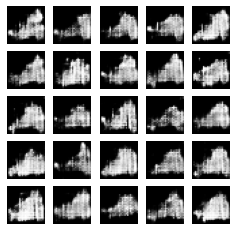

Time for epoch 3 is 41.11063098907471 sec


KeyboardInterrupt: 

In [29]:
train(train_dataset, 200)

In [30]:
conditional_gen.load_weights('fashion/training_weights/gen_1.h5')

In [31]:
# example of interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from matplotlib import pyplot

fig = plt.figure(figsize=(10,10))
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)


# load model
pts = generate_latent_points(100, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
from matplotlib import gridspec

output = None
for label in range(10):
    labels = tf.ones(10) * label
    predictions = conditional_gen([interpolated, labels], training=False)
    if output is None:
        output = predictions
    else:
        output = np.concatenate((output,predictions))

<Figure size 720x720 with 0 Axes>

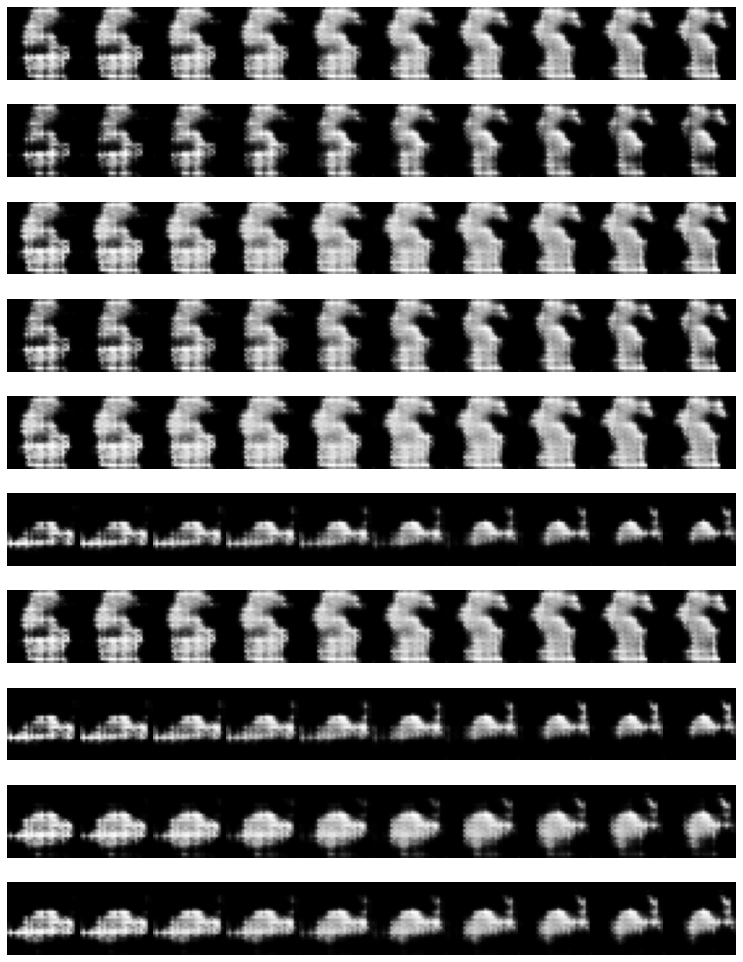

In [32]:
k = 0
nrow = 10
ncol = 10
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845) 


for i in range(10):
    for j in range(10):
        pred = (output[k, :, :, :] + 1 ) * 127.5
        ax= plt.subplot(gs[i,j])
        pred = np.array(pred)
        ax.imshow(pred.astype(np.uint8), cmap='gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.axis('off')
        k += 1   


plt.savefig('result.png',  dpi=300)
plt.show()

In [33]:
pred.shape

(28, 28, 1)